# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [17]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

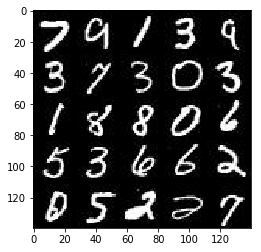

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

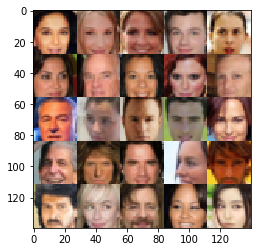

In [19]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [21]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real=tf.placeholder(dtype=tf.float32,shape=[None,image_width,image_height,image_channels],name="real")
    z=tf.placeholder(dtype=tf.float32,shape=[None,z_dim],name="z")
    learning_rate=tf.placeholder(dtype=tf.float32,name="lr")
    return real, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [22]:
def leaky_relu(tensor,alpha):
    return tf.maximum(alpha * tensor, tensor)

In [23]:
def discriminator(images, reuse=False,alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse) as scope:
        #conv1
        x1 = tf.contrib.layers.conv2d(images, num_outputs=64, kernel_size=5, stride=2,activation_fn=None,padding='same')
        relu1 = leaky_relu(x1,alpha)
        #conv2
        x2 = tf.contrib.layers.conv2d(relu1, 128, 5, stride=2,activation_fn=None, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        tanh = tf.tanh(bn2)
        #conv3
        x3 = tf.contrib.layers.conv2d(tanh, 256, 5, stride=2,activation_fn=None, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3,alpha)
        #print(relu3.get_shape())
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        #full_connect*2
        full1 = tf.layers.dense(flat, 512)
        logits = tf.layers.dense(full1, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def generator(z, out_channel_dim, is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train) as scope:
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1,alpha)
        # 4x4x512 now
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2,alpha)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.tanh(x3)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.tanh(x3)

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        logits = leaky_relu(logits,alpha)
        logits=tf.image.resize_images(logits, (28, 28))
        #print(logits.get_shape())
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [26]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #print(data_shape, data_image_mode)
    if(data_image_mode=="L"):image_channels=1
    elif(data_image_mode=="RGB"):image_channels=3
    else: raise error
    #print((data_shape[1], data_shape[1], image_channels, z_dim))
    real, z, lr=model_inputs(data_shape[1], data_shape[1], image_channels, z_dim)
    d_loss, g_loss=model_loss(real, z, image_channels,alpha=0.1)
    d_train_opt, g_train_opt=model_opt(d_loss, g_loss, lr, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for i,batch_images in enumerate(get_batches(batch_size)):
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                if i%10==0:
                    train_loss_d = d_loss.eval({z: batch_z, real: batch_images})
                    train_loss_g = g_loss.eval({z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if i%100 ==0:show_generator_output(sess, 16, z, image_channels, data_image_mode)

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={lr:learning_rate,real: batch_images, z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={lr:learning_rate,z: batch_z})
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.9705... Generator Loss: 1.1660


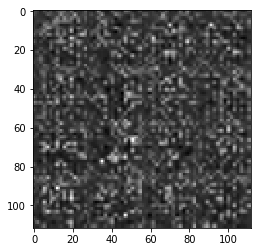

Epoch 1/2... Discriminator Loss: 1.2448... Generator Loss: 59.8263
Epoch 1/2... Discriminator Loss: 1.7713... Generator Loss: 2.7688
Epoch 1/2... Discriminator Loss: 2.0280... Generator Loss: 19.5610
Epoch 1/2... Discriminator Loss: 1.6614... Generator Loss: 20.0816
Epoch 1/2... Discriminator Loss: 2.1766... Generator Loss: 37.0686
Epoch 1/2... Discriminator Loss: 6.7453... Generator Loss: 13.1044
Epoch 1/2... Discriminator Loss: 3.9387... Generator Loss: 9.8945
Epoch 1/2... Discriminator Loss: 0.9305... Generator Loss: 6.0309
Epoch 1/2... Discriminator Loss: 3.2197... Generator Loss: 8.0217
Epoch 1/2... Discriminator Loss: 0.7827... Generator Loss: 4.0170


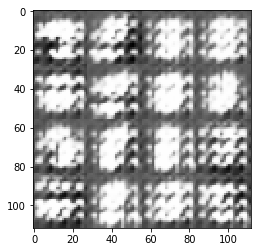

Epoch 1/2... Discriminator Loss: 0.6416... Generator Loss: 2.9821
Epoch 1/2... Discriminator Loss: 0.8155... Generator Loss: 2.1952
Epoch 1/2... Discriminator Loss: 0.7434... Generator Loss: 3.3691
Epoch 1/2... Discriminator Loss: 0.5632... Generator Loss: 4.8344
Epoch 1/2... Discriminator Loss: 0.5246... Generator Loss: 2.9188
Epoch 1/2... Discriminator Loss: 2.3505... Generator Loss: 0.4148
Epoch 1/2... Discriminator Loss: 0.5880... Generator Loss: 3.2032
Epoch 1/2... Discriminator Loss: 2.8118... Generator Loss: 11.0196
Epoch 1/2... Discriminator Loss: 0.9141... Generator Loss: 4.3771
Epoch 1/2... Discriminator Loss: 0.5588... Generator Loss: 3.1048


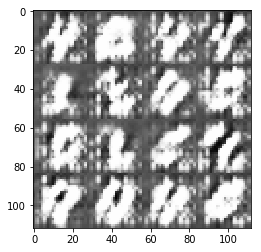

Epoch 1/2... Discriminator Loss: 0.4744... Generator Loss: 3.7729
Epoch 1/2... Discriminator Loss: 0.5365... Generator Loss: 4.1751
Epoch 1/2... Discriminator Loss: 0.8190... Generator Loss: 3.3033
Epoch 1/2... Discriminator Loss: 0.4656... Generator Loss: 3.9871
Epoch 1/2... Discriminator Loss: 0.5022... Generator Loss: 7.2478
Epoch 1/2... Discriminator Loss: 0.5221... Generator Loss: 4.1175
Epoch 1/2... Discriminator Loss: 0.4142... Generator Loss: 4.3781
Epoch 1/2... Discriminator Loss: 0.4760... Generator Loss: 3.1493
Epoch 1/2... Discriminator Loss: 0.4026... Generator Loss: 4.5707
Epoch 1/2... Discriminator Loss: 0.5657... Generator Loss: 4.1619


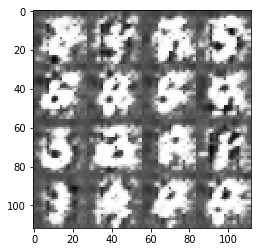

Epoch 1/2... Discriminator Loss: 0.4096... Generator Loss: 5.1128
Epoch 1/2... Discriminator Loss: 0.5092... Generator Loss: 6.8877
Epoch 1/2... Discriminator Loss: 0.4096... Generator Loss: 3.8697
Epoch 1/2... Discriminator Loss: 0.4509... Generator Loss: 3.1378
Epoch 1/2... Discriminator Loss: 3.7080... Generator Loss: 0.1720
Epoch 1/2... Discriminator Loss: 0.8348... Generator Loss: 3.6122
Epoch 1/2... Discriminator Loss: 0.9054... Generator Loss: 1.1791
Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 3.0239
Epoch 1/2... Discriminator Loss: 0.5017... Generator Loss: 3.1673
Epoch 1/2... Discriminator Loss: 0.4470... Generator Loss: 3.2334


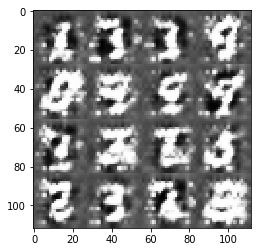

Epoch 1/2... Discriminator Loss: 0.4101... Generator Loss: 3.6041
Epoch 1/2... Discriminator Loss: 0.4149... Generator Loss: 3.7865
Epoch 1/2... Discriminator Loss: 0.4312... Generator Loss: 3.6620
Epoch 1/2... Discriminator Loss: 0.4609... Generator Loss: 3.2930
Epoch 1/2... Discriminator Loss: 0.4708... Generator Loss: 3.5698
Epoch 1/2... Discriminator Loss: 0.4643... Generator Loss: 3.4459
Epoch 2/2... Discriminator Loss: 0.5770... Generator Loss: 2.4426


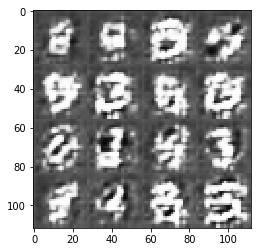

Epoch 2/2... Discriminator Loss: 0.4361... Generator Loss: 4.2006
Epoch 2/2... Discriminator Loss: 0.4186... Generator Loss: 4.6766
Epoch 2/2... Discriminator Loss: 0.3850... Generator Loss: 4.0071
Epoch 2/2... Discriminator Loss: 0.4274... Generator Loss: 4.5126
Epoch 2/2... Discriminator Loss: 0.4294... Generator Loss: 5.2387
Epoch 2/2... Discriminator Loss: 0.4094... Generator Loss: 3.8467
Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.7552
Epoch 2/2... Discriminator Loss: 0.7948... Generator Loss: 4.4221
Epoch 2/2... Discriminator Loss: 0.4261... Generator Loss: 3.2694
Epoch 2/2... Discriminator Loss: 0.4661... Generator Loss: 4.1448


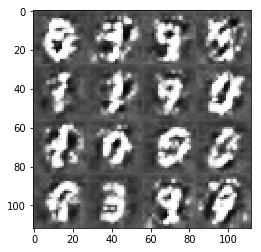

Epoch 2/2... Discriminator Loss: 0.4126... Generator Loss: 3.6657
Epoch 2/2... Discriminator Loss: 0.4027... Generator Loss: 4.1264
Epoch 2/2... Discriminator Loss: 0.3852... Generator Loss: 4.0381
Epoch 2/2... Discriminator Loss: 0.4051... Generator Loss: 3.7653
Epoch 2/2... Discriminator Loss: 0.3979... Generator Loss: 5.2057
Epoch 2/2... Discriminator Loss: 0.3919... Generator Loss: 4.3159
Epoch 2/2... Discriminator Loss: 0.3701... Generator Loss: 4.3770
Epoch 2/2... Discriminator Loss: 0.3618... Generator Loss: 4.7000
Epoch 2/2... Discriminator Loss: 0.3882... Generator Loss: 5.1550
Epoch 2/2... Discriminator Loss: 0.4291... Generator Loss: 3.2974


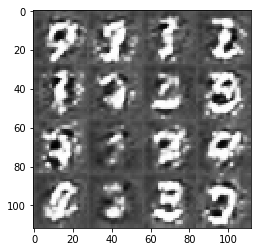

Epoch 2/2... Discriminator Loss: 0.3799... Generator Loss: 4.2454
Epoch 2/2... Discriminator Loss: 0.3824... Generator Loss: 3.9577
Epoch 2/2... Discriminator Loss: 0.3791... Generator Loss: 4.6890
Epoch 2/2... Discriminator Loss: 0.3642... Generator Loss: 5.3497
Epoch 2/2... Discriminator Loss: 0.4967... Generator Loss: 6.3699
Epoch 2/2... Discriminator Loss: 1.4921... Generator Loss: 1.1614
Epoch 2/2... Discriminator Loss: 0.7774... Generator Loss: 2.3662
Epoch 2/2... Discriminator Loss: 0.4714... Generator Loss: 2.7255
Epoch 2/2... Discriminator Loss: 0.4208... Generator Loss: 3.1961
Epoch 2/2... Discriminator Loss: 0.4636... Generator Loss: 3.9452


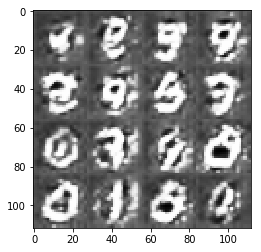

Epoch 2/2... Discriminator Loss: 0.3880... Generator Loss: 4.1377
Epoch 2/2... Discriminator Loss: 0.3956... Generator Loss: 3.6739
Epoch 2/2... Discriminator Loss: 0.3811... Generator Loss: 4.2424
Epoch 2/2... Discriminator Loss: 0.4647... Generator Loss: 3.0023
Epoch 2/2... Discriminator Loss: 0.3848... Generator Loss: 5.8297
Epoch 2/2... Discriminator Loss: 0.3865... Generator Loss: 4.0534
Epoch 2/2... Discriminator Loss: 0.3892... Generator Loss: 3.9599
Epoch 2/2... Discriminator Loss: 0.3780... Generator Loss: 5.0889
Epoch 2/2... Discriminator Loss: 0.3912... Generator Loss: 5.5265
Epoch 2/2... Discriminator Loss: 0.3561... Generator Loss: 6.0540


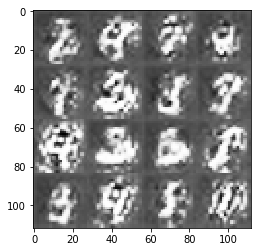

Epoch 2/2... Discriminator Loss: 0.3727... Generator Loss: 4.2857
Epoch 2/2... Discriminator Loss: 0.3724... Generator Loss: 5.0133
Epoch 2/2... Discriminator Loss: 0.3637... Generator Loss: 6.8950
Epoch 2/2... Discriminator Loss: 0.4462... Generator Loss: 3.2678
Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 9.6164
Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 1.6105


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.9259


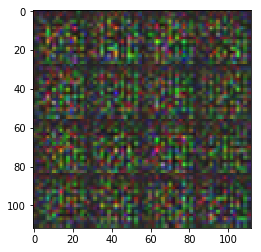

Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 16.7158
Epoch 1/1... Discriminator Loss: 1.8392... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 2.8182... Generator Loss: 35.8508
Epoch 1/1... Discriminator Loss: 1.7988... Generator Loss: 20.6630
Epoch 1/1... Discriminator Loss: 8.8208... Generator Loss: 0.1654
Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 6.9365
Epoch 1/1... Discriminator Loss: 2.2395... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 6.7741... Generator Loss: 20.3567
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.5627
Epoch 1/1... Discriminator Loss: 4.3602... Generator Loss: 0.2601


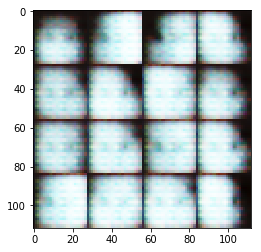

Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 2.9325
Epoch 1/1... Discriminator Loss: 0.5653... Generator Loss: 2.9170
Epoch 1/1... Discriminator Loss: 1.7490... Generator Loss: 6.7153
Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 3.6408
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 6.0053
Epoch 1/1... Discriminator Loss: 3.4401... Generator Loss: 0.1625
Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 2.0795
Epoch 1/1... Discriminator Loss: 0.4818... Generator Loss: 4.4358
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 3.2850
Epoch 1/1... Discriminator Loss: 0.5393... Generator Loss: 3.4830


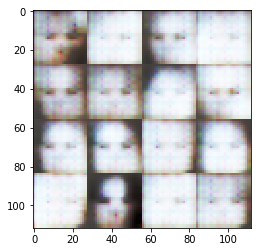

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 9.6529
Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 5.6987
Epoch 1/1... Discriminator Loss: 0.6712... Generator Loss: 5.6320
Epoch 1/1... Discriminator Loss: 0.6513... Generator Loss: 3.3031
Epoch 1/1... Discriminator Loss: 0.5670... Generator Loss: 4.5420
Epoch 1/1... Discriminator Loss: 0.4460... Generator Loss: 3.6051
Epoch 1/1... Discriminator Loss: 0.3829... Generator Loss: 7.4952
Epoch 1/1... Discriminator Loss: 1.7346... Generator Loss: 12.0051
Epoch 1/1... Discriminator Loss: 2.0864... Generator Loss: 12.2309
Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 5.1556


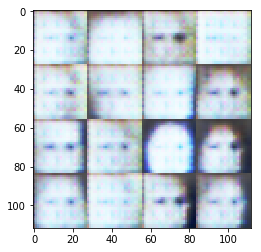

Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 5.0681
Epoch 1/1... Discriminator Loss: 0.4371... Generator Loss: 3.9765
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 10.1745
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 0.5341... Generator Loss: 3.7302
Epoch 1/1... Discriminator Loss: 0.5402... Generator Loss: 3.1866
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 3.7790
Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 3.9050
Epoch 1/1... Discriminator Loss: 0.4203... Generator Loss: 4.6776
Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 2.5169


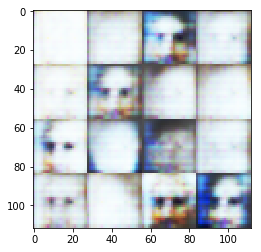

Epoch 1/1... Discriminator Loss: 0.6028... Generator Loss: 1.8444
Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 6.6723
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 6.6196
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 2.6702
Epoch 1/1... Discriminator Loss: 0.5365... Generator Loss: 2.1968
Epoch 1/1... Discriminator Loss: 5.5744... Generator Loss: 16.7734
Epoch 1/1... Discriminator Loss: 0.5406... Generator Loss: 3.7181
Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 4.7262
Epoch 1/1... Discriminator Loss: 0.5179... Generator Loss: 3.2905
Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 5.4307


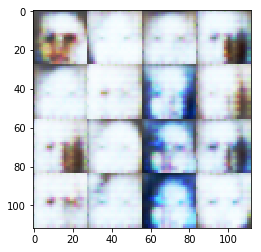

Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 4.3105
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 4.8878
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 3.5640
Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 3.0842
Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 4.9371
Epoch 1/1... Discriminator Loss: 0.3814... Generator Loss: 10.2720
Epoch 1/1... Discriminator Loss: 0.4449... Generator Loss: 3.4301
Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 4.5767
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 1.8933
Epoch 1/1... Discriminator Loss: 0.5216... Generator Loss: 4.3084


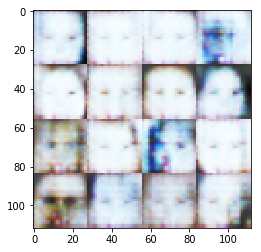

Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 7.3694
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 3.1945
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 4.0476
Epoch 1/1... Discriminator Loss: 0.4510... Generator Loss: 6.7007
Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 4.5475
Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 5.2642
Epoch 1/1... Discriminator Loss: 0.5170... Generator Loss: 2.4883
Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 5.8144
Epoch 1/1... Discriminator Loss: 0.3800... Generator Loss: 6.8553
Epoch 1/1... Discriminator Loss: 0.4818... Generator Loss: 5.2438


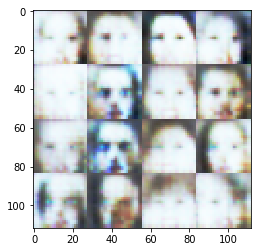

Epoch 1/1... Discriminator Loss: 0.4405... Generator Loss: 4.8042
Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 2.1591
Epoch 1/1... Discriminator Loss: 0.4423... Generator Loss: 3.9446
Epoch 1/1... Discriminator Loss: 0.4511... Generator Loss: 4.9958
Epoch 1/1... Discriminator Loss: 0.3706... Generator Loss: 5.8046
Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 7.1348
Epoch 1/1... Discriminator Loss: 0.3642... Generator Loss: 5.9234
Epoch 1/1... Discriminator Loss: 0.3714... Generator Loss: 5.8888
Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 5.3430
Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.4981


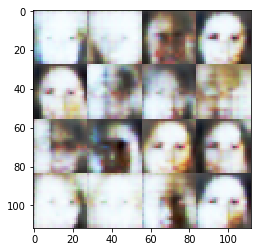

Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 4.1172
Epoch 1/1... Discriminator Loss: 0.4285... Generator Loss: 4.1877
Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 5.8556
Epoch 1/1... Discriminator Loss: 0.4056... Generator Loss: 4.0350
Epoch 1/1... Discriminator Loss: 0.3644... Generator Loss: 7.2360
Epoch 1/1... Discriminator Loss: 0.3737... Generator Loss: 7.3632
Epoch 1/1... Discriminator Loss: 0.3550... Generator Loss: 6.8458
Epoch 1/1... Discriminator Loss: 0.3756... Generator Loss: 4.4586
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 5.4126
Epoch 1/1... Discriminator Loss: 0.3827... Generator Loss: 5.3806


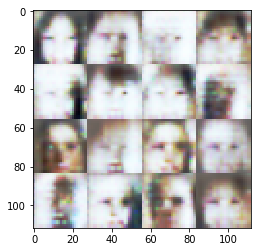

Epoch 1/1... Discriminator Loss: 0.3821... Generator Loss: 5.2892
Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 3.0972
Epoch 1/1... Discriminator Loss: 0.4105... Generator Loss: 3.8460
Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 4.1964
Epoch 1/1... Discriminator Loss: 0.3690... Generator Loss: 4.9332
Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 7.1053
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 3.6084
Epoch 1/1... Discriminator Loss: 0.6851... Generator Loss: 2.6047
Epoch 1/1... Discriminator Loss: 0.3803... Generator Loss: 6.6472
Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 2.4924


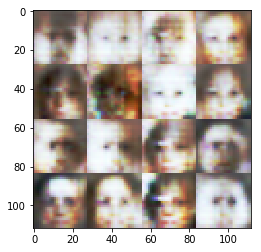

Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 5.2541
Epoch 1/1... Discriminator Loss: 0.3910... Generator Loss: 3.6657
Epoch 1/1... Discriminator Loss: 0.4017... Generator Loss: 3.3098
Epoch 1/1... Discriminator Loss: 0.3726... Generator Loss: 5.8920
Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 7.4800
Epoch 1/1... Discriminator Loss: 0.3476... Generator Loss: 6.0396
Epoch 1/1... Discriminator Loss: 0.3774... Generator Loss: 7.0752
Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 4.6894
Epoch 1/1... Discriminator Loss: 0.4389... Generator Loss: 3.5358
Epoch 1/1... Discriminator Loss: 0.3664... Generator Loss: 4.7451


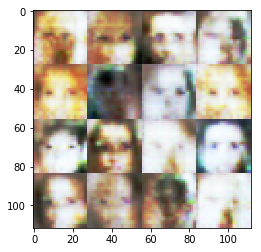

Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 6.7243
Epoch 1/1... Discriminator Loss: 0.3517... Generator Loss: 5.3005
Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 5.8881
Epoch 1/1... Discriminator Loss: 0.6001... Generator Loss: 4.7098
Epoch 1/1... Discriminator Loss: 0.4228... Generator Loss: 3.3666
Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 4.3942
Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 4.3208
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 7.4384
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 6.3732
Epoch 1/1... Discriminator Loss: 0.3473... Generator Loss: 6.9889


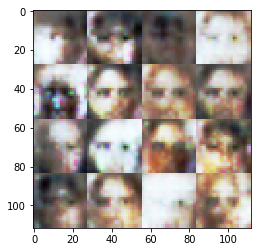

Epoch 1/1... Discriminator Loss: 0.3586... Generator Loss: 6.3389
Epoch 1/1... Discriminator Loss: 0.3958... Generator Loss: 5.5069
Epoch 1/1... Discriminator Loss: 0.3808... Generator Loss: 4.2292
Epoch 1/1... Discriminator Loss: 0.3414... Generator Loss: 8.2471
Epoch 1/1... Discriminator Loss: 0.3600... Generator Loss: 4.7826
Epoch 1/1... Discriminator Loss: 0.4111... Generator Loss: 3.7681
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 4.7128
Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 6.0073
Epoch 1/1... Discriminator Loss: 0.3644... Generator Loss: 4.7352
Epoch 1/1... Discriminator Loss: 0.4159... Generator Loss: 6.1053


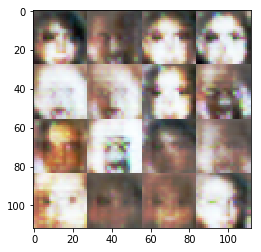

Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 3.9382
Epoch 1/1... Discriminator Loss: 0.3702... Generator Loss: 5.5798
Epoch 1/1... Discriminator Loss: 0.3748... Generator Loss: 6.7269
Epoch 1/1... Discriminator Loss: 0.3452... Generator Loss: 5.3409
Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 6.9770
Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 5.4527
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 7.2891
Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 6.6295
Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 4.5108
Epoch 1/1... Discriminator Loss: 0.3734... Generator Loss: 6.6904


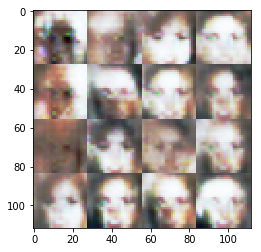

Epoch 1/1... Discriminator Loss: 0.3402... Generator Loss: 6.8424
Epoch 1/1... Discriminator Loss: 0.3410... Generator Loss: 6.0553
Epoch 1/1... Discriminator Loss: 0.3446... Generator Loss: 5.7088
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 0.4186... Generator Loss: 5.1425
Epoch 1/1... Discriminator Loss: 0.4166... Generator Loss: 4.4639
Epoch 1/1... Discriminator Loss: 0.3767... Generator Loss: 6.0855
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 7.7236
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 4.6048
Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 4.5152


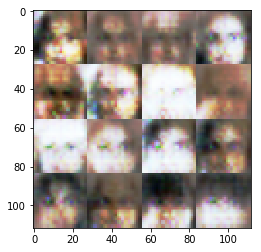

Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 6.0967
Epoch 1/1... Discriminator Loss: 0.3479... Generator Loss: 6.0064
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 6.3621
Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 7.4011
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 5.5791
Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 4.9414
Epoch 1/1... Discriminator Loss: 0.3390... Generator Loss: 9.4927
Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 8.6565


In [30]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1 #

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

In [31]:
print("OK")

OK
